In [12]:
"""!pip install ffn
!pip install pypfopt
!pip install empyrical"""

'!pip install ffn\n!pip install pypfopt\n!pip install empyrical'

In [13]:
#pip install seaborn



In [14]:
#pip install skforecast

In [15]:
import ffn

import numpy as np
import pandas as pd
#from empyrical import alpha_beta
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import warnings
plt.style.use('dark_background')
#warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [16]:

folder = '../data/'
file = 'ffn.csv'
filename = f"{folder}{file}"
isin='LU0843168575'
filename

isins=['LU0280438135','LU0255977372','LU0133806785']

In [17]:
isins = ['LU0340554673','LU0474966677','LU0386875149']
filename = 'portfolios/ptf_18062022203808.csv'
prices = ffn.get(f'{isins[0]},{isins[1]},{isins[2]}', provider=ffn.data.csv, path=filename)
prices


,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,330.60,143.93,246.40
2018-01-05,335.11,144.46,248.83
2018-01-09,338.47,147.21,251.80
2018-01-10,335.02,148.57,249.46
2018-01-11,334.65,148.47,249.42
...,...,...,...
2022-06-07,428.18,161.76,351.37
2022-06-08,437.47,161.89,354.28
2022-06-09,435.12,162.10,351.29


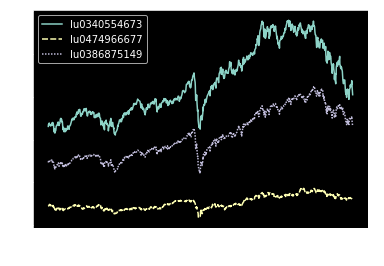

In [18]:
sns.lineplot(data=prices)
plt.show()

In [19]:
#prices = ffn.get('TTWO, CCOEY, EA', start='2019-01-01')
#benchmark = ffn.get(f'{isins[0]}-level',provider=ffn.data.csv, path=filename)
#ax = prices.rebase().plot(figsize=(12,5))
#plt.show()

In [20]:
prices

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,330.60,143.93,246.40
2018-01-05,335.11,144.46,248.83
2018-01-09,338.47,147.21,251.80
2018-01-10,335.02,148.57,249.46
2018-01-11,334.65,148.47,249.42
...,...,...,...
2022-06-07,428.18,161.76,351.37
2022-06-08,437.47,161.89,354.28
2022-06-09,435.12,162.10,351.29


In [21]:
returns = prices.to_returns().dropna()

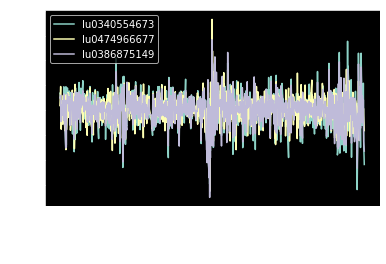

In [22]:
returns.plot()
plt.show()

In [23]:
stats = prices.calc_stats()
stats.display()

Stat                 lu0340554673    lu0474966677    lu0386875149
-------------------  --------------  --------------  --------------
Start                2018-01-04      2018-01-04      2018-01-04
End                  2022-06-13      2022-06-13      2022-06-13
Risk-free rate       0.00%           0.00%           0.00%

Total Return         22.38%          10.21%          34.31%
Daily Sharpe         0.34            0.23            0.50
Daily Sortino        0.54            0.37            0.76
CAGR                 4.66%           2.21%           6.87%
Max Drawdown         -31.93%         -26.86%         -32.25%
Calmar Ratio         0.15            0.08            0.21

MTD                  -3.90%          -3.45%          -5.48%
3m                   -8.26%          -2.44%          -7.60%
6m                   -23.47%         -12.11%         -19.18%
YTD                  -23.91%         -11.36%         -20.61%
1Y                   -26.09%         -6.09%          -12.81%
3Y (ann.)           

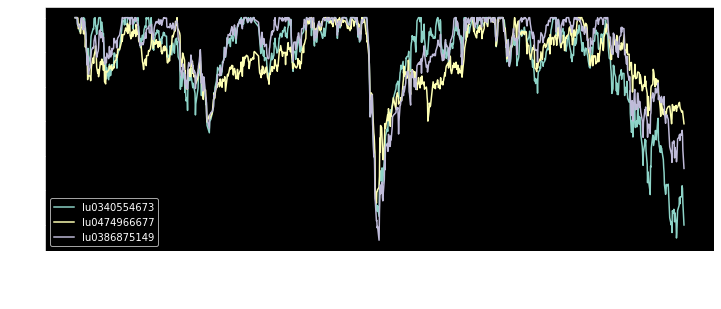

In [24]:
stats.prices.to_drawdown_series().plot(figsize=(12,5))
plt.show()

In [25]:
stats.prices.calc_cagr()

lu0340554673    0.046565
lu0474966677    0.022139
lu0386875149    0.068725
dtype: float64

In [26]:
returns = prices.to_log_returns().dropna()
returns.calc_mean_var_weights().as_format('.2%')

lu0340554673     0.00%
lu0474966677     0.11%
lu0386875149    99.89%
dtype: object

In [27]:
returns.calc_erc_weights().as_format('.2%')

lu0340554673    27.54%
lu0474966677    41.10%
lu0386875149    31.36%
Name: erc, dtype: object

symbols = [f'{isin}-NAV']
for sym in symbols:
    stk = ffn.get(sym, provider=ffn.data.csv, path=filename)
    alpha, beta = alpha_beta(stk, benchmark)
    print(sym, beta)


In [28]:
returns = prices.pct_change()
weight = np.array([10,10,10])

t = np.sum(weight)
weights = weight/t
# mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

print("Expected annualised return: " + str(portfolio_return*100))
print("Volatility: " + str(portfolio_std_dev*100))

Expected annualised return: 7.000000000000001
Volatility: 16.0


In [29]:
portfolio_return

0.07

In [30]:
mean_daily_returns

lu0340554673    0.000286
lu0474966677    0.000151
lu0386875149    0.000355
dtype: float64

In [31]:
returns

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,NaN,NaN,NaN
2018-01-05,0.013642,0.003682,0.009862
2018-01-09,0.010027,0.019036,0.011936
2018-01-10,-0.010193,0.009239,-0.009293
2018-01-11,-0.001104,-0.000673,-0.000160
...,...,...,...
2022-06-07,-0.000327,-0.006693,-0.002017
2022-06-08,0.021696,0.000804,0.008282
2022-06-09,-0.005372,0.001297,-0.008440


In [32]:
portfolio_return

0.07

In [33]:
prices.iloc[0]

lu0340554673    330.60
lu0474966677    143.93
lu0386875149    246.40
Name: 2018-01-04 00:00:00, dtype: float64

In [34]:
#pip install PyPortfolioOpt

In [35]:
prices

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,330.60,143.93,246.40
2018-01-05,335.11,144.46,248.83
2018-01-09,338.47,147.21,251.80
2018-01-10,335.02,148.57,249.46
2018-01-11,334.65,148.47,249.42
...,...,...,...
2022-06-07,428.18,161.76,351.37
2022-06-08,437.47,161.89,354.28
2022-06-09,435.12,162.10,351.29


In [36]:
x=ffn.core.drawdown_details(ffn.core.calc_max_drawdown(prices))

In [37]:
ffn.core.GroupStats(prices).display()

Stat                 lu0340554673    lu0474966677    lu0386875149
-------------------  --------------  --------------  --------------
Start                2018-01-04      2018-01-04      2018-01-04
End                  2022-06-13      2022-06-13      2022-06-13
Risk-free rate       0.00%           0.00%           0.00%

Total Return         22.38%          10.21%          34.31%
Daily Sharpe         0.34            0.23            0.50
Daily Sortino        0.54            0.37            0.76
CAGR                 4.66%           2.21%           6.87%
Max Drawdown         -31.93%         -26.86%         -32.25%
Calmar Ratio         0.15            0.08            0.21

MTD                  -3.90%          -3.45%          -5.48%
3m                   -8.26%          -2.44%          -7.60%
6m                   -23.47%         -12.11%         -19.18%
YTD                  -23.91%         -11.36%         -20.61%
1Y                   -26.09%         -6.09%          -12.81%
3Y (ann.)           

In [38]:
100*((1*(106.56/100))+(1*(229.62/100))+(1*(80.63/100))-3)

116.81000000000009

In [39]:
(((1*(106.56/100)))+1)+(((1*(229.62/100)))+1)+(((1*(80.63/100)))+1)-3


4.168100000000001

In [40]:
(((1*(229.62/100)))+1)/3

1.0987333333333333

In [41]:
((1*(80.63/100)))+1

1.8062999999999998

In [42]:
pf?

Object `pf` not found.


In [43]:
prices

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,330.60,143.93,246.40
2018-01-05,335.11,144.46,248.83
2018-01-09,338.47,147.21,251.80
2018-01-10,335.02,148.57,249.46
2018-01-11,334.65,148.47,249.42
...,...,...,...
2022-06-07,428.18,161.76,351.37
2022-06-08,437.47,161.89,354.28
2022-06-09,435.12,162.10,351.29


In [44]:
returns 

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,NaN,NaN,NaN
2018-01-05,0.013642,0.003682,0.009862
2018-01-09,0.010027,0.019036,0.011936
2018-01-10,-0.010193,0.009239,-0.009293
2018-01-11,-0.001104,-0.000673,-0.000160
...,...,...,...
2022-06-07,-0.000327,-0.006693,-0.002017
2022-06-08,0.021696,0.000804,0.008282
2022-06-09,-0.005372,0.001297,-0.008440


In [45]:
p = prices.copy()

In [46]:
p

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04,330.60,143.93,246.40
2018-01-05,335.11,144.46,248.83
2018-01-09,338.47,147.21,251.80
2018-01-10,335.02,148.57,249.46
2018-01-11,334.65,148.47,249.42
...,...,...,...
2022-06-07,428.18,161.76,351.37
2022-06-08,437.47,161.89,354.28
2022-06-09,435.12,162.10,351.29


In [47]:
p.index = p.index.tz_localize('utc')

In [48]:
p

,lu0340554673,lu0474966677,lu0386875149
index,,,
2018-01-04 00:00:00+00:00,330.60,143.93,246.40
2018-01-05 00:00:00+00:00,335.11,144.46,248.83
2018-01-09 00:00:00+00:00,338.47,147.21,251.80
2018-01-10 00:00:00+00:00,335.02,148.57,249.46
2018-01-11 00:00:00+00:00,334.65,148.47,249.42
...,...,...,...
2022-06-07 00:00:00+00:00,428.18,161.76,351.37
2022-06-08 00:00:00+00:00,437.47,161.89,354.28
2022-06-09 00:00:00+00:00,435.12,162.10,351.29


In [49]:
prices.loc[:,'p1']=20
prices.loc[:,'p2']=30
prices.loc[:,'p3']=50
returns.loc['2022-01-04','p1']=20



In [50]:
returns

,lu0340554673,lu0474966677,lu0386875149,p1
index,,,,
2018-01-04,NaN,NaN,NaN,NaN
2018-01-05,0.013642,0.003682,0.009862,NaN
2018-01-09,0.010027,0.019036,0.011936,NaN
2018-01-10,-0.010193,0.009239,-0.009293,NaN
2018-01-11,-0.001104,-0.000673,-0.000160,NaN
...,...,...,...,...
2022-06-07,-0.000327,-0.006693,-0.002017,NaN
2022-06-08,0.021696,0.000804,0.008282,NaN
2022-06-09,-0.005372,0.001297,-0.008440,NaN


In [51]:
prices

,lu0340554673,lu0474966677,lu0386875149,p1,p2,p3
index,,,,,,
2018-01-04,330.60,143.93,246.40,20,30,50
2018-01-05,335.11,144.46,248.83,20,30,50
2018-01-09,338.47,147.21,251.80,20,30,50
2018-01-10,335.02,148.57,249.46,20,30,50
2018-01-11,334.65,148.47,249.42,20,30,50
...,...,...,...,...,...,...
2022-06-07,428.18,161.76,351.37,20,30,50
2022-06-08,437.47,161.89,354.28,20,30,50
2022-06-09,435.12,162.10,351.29,20,30,50


In [52]:
523.83/531.61*20

19.707304226782792

In [53]:
returns_1 = returns + 1
returns_1.loc['2018-01-04','p1']=20
returns_1.loc['2018-01-04','p2']=30
returns_1.loc['2018-01-04','p3']=50
returns_1

,lu0340554673,lu0474966677,lu0386875149,p1,p2,p3
index,,,,,,
2018-01-04,NaN,NaN,NaN,20.0,30.0,50.0
2018-01-05,1.013642,1.003682,1.009862,NaN,NaN,NaN
2018-01-09,1.010027,1.019036,1.011936,NaN,NaN,NaN
2018-01-10,0.989807,1.009239,0.990707,NaN,NaN,NaN
2018-01-11,0.998896,0.999327,0.999840,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-06-07,0.999673,0.993307,0.997983,NaN,NaN,NaN
2022-06-08,1.021696,1.000804,1.008282,NaN,NaN,NaN
2022-06-09,0.994628,1.001297,0.991560,NaN,NaN,NaN


In [54]:
for i in range(1,1017):
    returns_1.iloc[i,3] = returns_1.iloc[i-1,3] * returns_1.iloc[i,0]
    returns_1.iloc[i,4] = returns_1.iloc[i-1,4] * returns_1.iloc[i,1]
    returns_1.iloc[i,5] = returns_1.iloc[i-1,5] * returns_1.iloc[i,2]
    

In [55]:
returns_1['p']=returns_1['p1']+returns_1['p3']+returns_1['p2']

In [56]:
returns_1

,lu0340554673,lu0474966677,lu0386875149,p1,p2,p3,p
index,,,,,,,
2018-01-04,NaN,NaN,NaN,20.000000,30.000000,50.000000,100.000000
2018-01-05,1.013642,1.003682,1.009862,20.272837,30.110470,50.493101,100.876408
2018-01-09,1.010027,1.019036,1.011936,20.476104,30.683666,51.095779,102.255549
2018-01-10,0.989807,1.009239,0.990707,20.267393,30.967137,50.620942,101.855471
2018-01-11,0.998896,0.999327,0.999840,20.245009,30.946293,50.612825,101.804127
...,...,...,...,...,...,...,...
2022-06-07,0.999673,0.993307,0.997983,25.903206,33.716390,71.300731,130.920327
2022-06-08,1.021696,1.000804,1.008282,26.465215,33.743486,71.891234,132.099935
2022-06-09,0.994628,1.001297,0.991560,26.323049,33.787258,71.284497,131.394803


In [57]:
portfolio = returns_1['p']
pd.DataFrame(portfolio).to_csv('portfolios/ptf1a.csv')

In [58]:
isins = ['p']
filename = 'portfolios/ptf1a.csv'
ptf_prices = ffn.get(f'{isins[0]}', provider=ffn.data.csv, path=filename)
ptf_prices


,p
index,
2018-01-04,100.000000
2018-01-05,100.876408
2018-01-09,102.255549
2018-01-10,101.855471
2018-01-11,101.804127
...,...
2022-06-07,130.920327
2022-06-08,132.099935
2022-06-09,131.394803


In [59]:
ptf_stats = ptf_prices.calc_stats()

In [60]:
ffn.core.GroupStats(ptf_prices).display()

Stat                 p
-------------------  ----------
Start                2018-01-04
End                  2022-06-13
Risk-free rate       0.00%

Total Return         24.69%
Daily Sharpe         0.43
Daily Sortino        0.66
CAGR                 5.10%
Max Drawdown         -29.05%
Calmar Ratio         0.18

MTD                  -4.64%
3m                   -6.42%
6m                   -18.34%
YTD                  -19.06%
1Y                   -14.21%
3Y (ann.)            5.57%
5Y (ann.)            5.10%
10Y (ann.)           -
Since Incep. (ann.)  5.10%

Daily Sharpe         0.43
Daily Sortino        0.66
Daily Mean (ann.)    6.73%
Daily Vol (ann.)     15.82%
Daily Skew           -0.45
Daily Kurt           3.64
Best Day             4.85%
Worst Day            -5.53%

Monthly Sharpe       0.42
Monthly Sortino      0.68
Monthly Mean (ann.)  6.01%
Monthly Vol (ann.)   14.34%
Monthly Skew         -0.34
Monthly Kurt         0.79
Best Month           11.23%
Worst Month          -9.35%

Yearly Sh

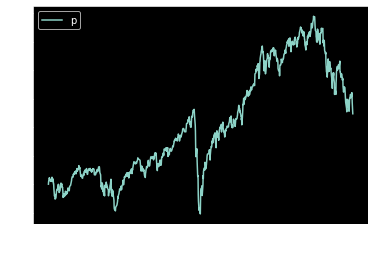

In [61]:
sns.lineplot(data=ptf_prices)
plt.show()

In [62]:
data = ptf_prices.reset_index().copy()
data

,index,p
0,2018-01-04,100.000000
1,2018-01-05,100.876408
2,2018-01-09,102.255549
3,2018-01-10,101.855471
4,2018-01-11,101.804127
...,...,...
1012,2022-06-07,130.920327
1013,2022-06-08,132.099935
1014,2022-06-09,131.394803
1015,2022-06-10,128.662094


In [63]:
data['month'] = [i.month for i in data['index']]
data['year'] = [i.year for i in data['index']]
data['day_of_week'] = [i.dayofweek for i in data['index']]
data['day_of_year'] = [i.dayofyear for i in data['index']]


In [64]:
data

,index,p,month,year,day_of_week,day_of_year
0,2018-01-04,100.000000,1,2018,3,4
1,2018-01-05,100.876408,1,2018,4,5
2,2018-01-09,102.255549,1,2018,1,9
3,2018-01-10,101.855471,1,2018,2,10
4,2018-01-11,101.804127,1,2018,3,11
...,...,...,...,...,...,...
1012,2022-06-07,130.920327,6,2022,1,158
1013,2022-06-08,132.099935,6,2022,2,159
1014,2022-06-09,131.394803,6,2022,3,160
1015,2022-06-10,128.662094,6,2022,4,161


In [65]:
data.year.value_counts()

2021    233
2018    230
2020    229
2019    226
2022     99
Name: year, dtype: int64

In [66]:
train = data[data['year'] < 2021]
test = data[data['year'] >= 2021]

In [67]:
#pip install pycaret 

In [68]:
ptf_prices

,p
index,
2018-01-04,100.000000
2018-01-05,100.876408
2018-01-09,102.255549
2018-01-10,101.855471
2018-01-11,101.804127
...,...
2022-06-07,130.920327
2022-06-08,132.099935
2022-06-09,131.394803


In [69]:
data = ptf_prices.copy()

# Fill gaps in a temporary index
# ==============================================================================
data.asfreq(freq='d', method='bfill')
# Verify that a temporary index is complete


,p
index,
2018-01-04,100.000000
2018-01-05,100.876408
2018-01-06,102.255549
2018-01-07,102.255549
2018-01-08,102.255549
...,...
2022-06-09,131.394803
2022-06-10,128.662094
2022-06-11,124.693647


In [70]:
data = data.asfreq('d')
print(data.index.freq)

<Day>


In [71]:
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [72]:
data.fillna(method='bfill', inplace=True)
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [73]:
data.shape

(1622, 1)

In [74]:
data.columns

Index(['p'], dtype='object')

In [75]:
data

,p
index,
2018-01-04,100.000000
2018-01-05,100.876408
2018-01-06,102.255549
2018-01-07,102.255549
2018-01-08,102.255549
...,...
2022-06-09,131.394803
2022-06-10,128.662094
2022-06-11,124.693647


Train dates : 2018-01-04 00:00:00 --- 2020-09-29 00:00:00  (n=1000)
Test dates  : 2020-09-30 00:00:00 --- 2022-06-13 00:00:00  (n=622)


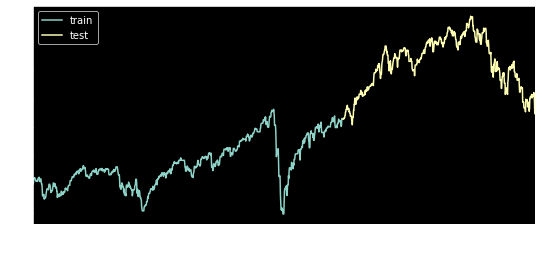

In [76]:
# Split data into train-test
# ==============================================================================
steps = 622
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['p'].plot(ax=ax, label='train')
data_test['p'].plot(ax=ax, label='test')
ax.legend();

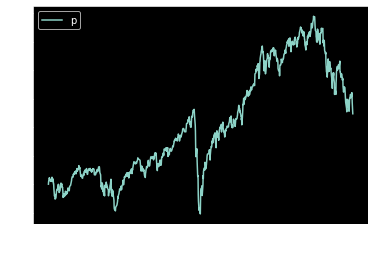

In [77]:
sns.lineplot(data=ptf_prices)
plt.show()

In [78]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 365
                )

forecaster.fit(y=data_train['p'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 22

In [79]:
# Predictions
# ==============================================================================
steps = 622
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2020-09-30    122.807780
2020-10-01    122.666262
2020-10-02    122.450122
2020-10-03    122.405757
2020-10-04    121.914804
Freq: D, Name: pred, dtype: float64

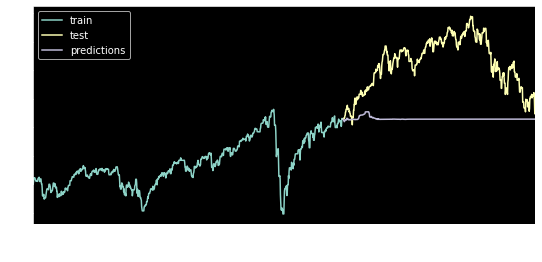

In [80]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['p'].plot(ax=ax, label='train')
data_test['p'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [81]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['p'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 454.2149287295199
